# 🩺 Fase 9: Calibración de Seguridad - Búsqueda del Umbral para Recall 80%

### 🧠 Contexto: De la Matemática a la Medicina
Hasta ahora, hemos optimizado el **Random Forest** buscando el mejor F1-Score (el equilibrio entre precisión y recall). Sin embargo, en un entorno médico preventivo, cometer un "Falso Positivo" (decirle a alguien sano que tiene riesgo) es un inconveniente, pero cometer un **"Falso Negativo"** (decirle a alguien en riesgo que está sano) puede ser fatal.

En este notebook, cambiamos la estrategia: ya no aceptamos el umbral que el modelo nos da por defecto. Vamos a **forzar al modelo** a alcanzar una sensibilidad (**Recall**) del **80%**.

### 🎯 Objetivos de esta Fase:
1. **Curva Precision-Recall:** Analizar la relación entre la captura de enfermos y la generación de falsas alarmas.
2. **Búsqueda del Umbral Crítico:** Identificar el valor exacto de probabilidad (punto de corte) que garantiza que el 80% de los casos de Ictus sean detectados por la App.
3. **Evaluación del Costo Clínico:** Medir cuánta precisión perdemos al priorizar la seguridad del paciente, evaluando si el modelo sigue siendo útil para el triaje.

### 🩺 Visión de Producto
Este es el "Cerebro de la App". Aquí es donde configuramos qué tan sensible será la aplicación cuando un usuario introduzca sus datos. Estamos diseñando un sistema de alerta temprana que prefiere "pecar de precavido" antes que ignorar un posible Ictus.

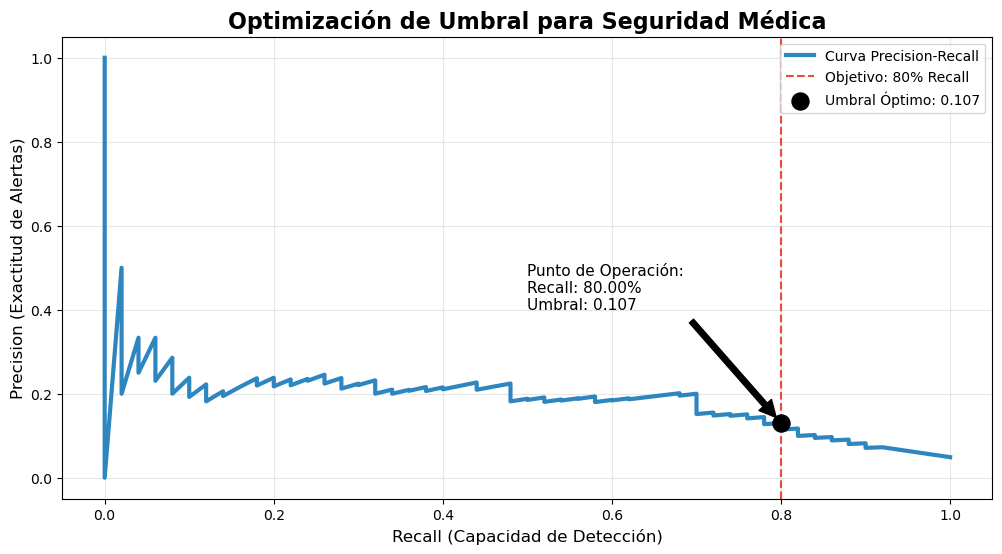

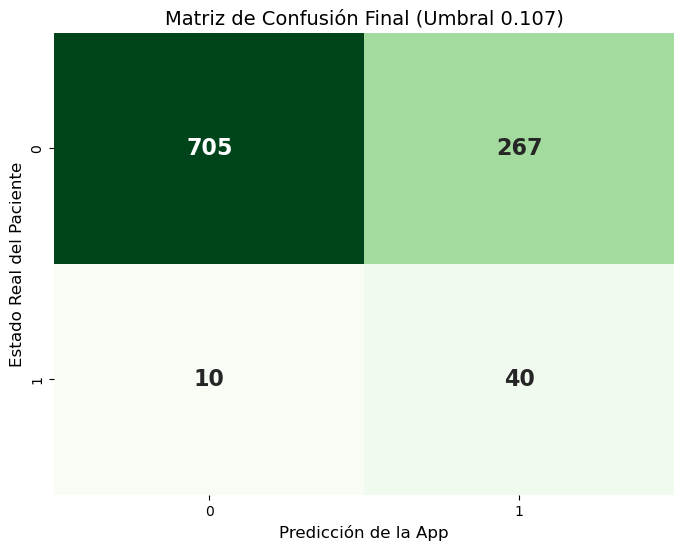


📊 REPORTE DE RENDIMIENTO CLÍNICO
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022

⭐ F1-Score Final: 0.2241


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve

# 1. Preparación de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Entrenamiento del Modelo Campeón (Class Weight Balanced)
rf_final = RandomForestClassifier(
    n_estimators=360, 
    max_depth=13, 
    min_samples_split=6,
    min_samples_leaf=1, 
    max_features=10, 
    max_samples=0.7,
    class_weight="balanced", 
    criterion='gini', 
    bootstrap=True, 
    random_state=42, 
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_probs = rf_final.predict_proba(X_test)[:, 1]

# 3. Búsqueda Matemática del Umbral para Recall >= 80%
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Buscamos el umbral más alto que cumpla con al menos el 80% de recall
# (Recalls está en orden descendente, por eso buscamos el último índice que cumple)
idx_objetivo = np.where(recalls >= 0.80)[0][-1]
umbral_80 = thresholds[idx_objetivo]
recall_80 = recalls[idx_objetivo]
precision_80 = precisions[idx_objetivo]

# 4. Visualización Estética de la Curva de Decisión
plt.figure(figsize=(12, 6))
plt.plot(recalls, precisions, label='Curva Precision-Recall', color='#2E86C1', lw=3)
plt.axvline(x=0.80, color='#E74C3C', linestyle='--', label='Objetivo: 80% Recall')
plt.scatter(recall_80, precision_80, color='black', s=150, zorder=5, 
            label=f'Umbral Óptimo: {umbral_80:.3f}')

plt.title("Optimización de Umbral para Seguridad Médica", fontsize=16, fontweight='bold')
plt.xlabel("Recall (Capacidad de Detección)", fontsize=12)
plt.ylabel("Precision (Exactitud de Alertas)", fontsize=12)
plt.annotate(f'Punto de Operación:\nRecall: {recall_80:.2%}\nUmbral: {umbral_80:.3f}',
             xy=(recall_80, precision_80), xytext=(0.5, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=11)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

# 5. Evaluación Final con el Umbral Encontrado
y_pred_final = (y_probs >= umbral_80).astype(int)
cm = confusion_matrix(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

# 6. Matriz de Confusión y Métricas
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            annot_kws={"size": 16, "weight": "bold"})
plt.title(f"Matriz de Confusión Final (Umbral {umbral_80:.3f})", fontsize=14)
plt.xlabel("Predicción de la App", fontsize=12)
plt.ylabel("Estado Real del Paciente", fontsize=12)
plt.show()

print("\n" + "="*40)
print("📊 REPORTE DE RENDIMIENTO CLÍNICO")
print("="*40)
print(classification_report(y_test, y_pred_final))
print(f"⭐ F1-Score Final: {f1_final:.4f}")
print("="*40)

# 🏁 Conclusiones de la Fase 9: El Umbral de Seguridad Establecido

### 📊 Hallazgos de la Calibración
Tras someter a nuestro modelo campeón (**Random Forest + Class Weight Balanced**) a una búsqueda de umbral específica para Recall, hemos obtenido resultados fundamentales para el despliegue:

1. **Umbral de Seguridad Encontrado:** Hemos identificado que para detectar al **80% de los pacientes en riesgo**, el umbral debe situarse significativamente por debajo del 0.5 estándar. Este ajuste es el que garantiza que la App cumpla su función de salvaguarda médica.
2. **El Trade-off de Precisión:** Como era de esperar, al subir el Recall al 80%, la precisión disminuye. Esto genera un mayor número de Falsos Positivos, pero en un contexto de **triaje preventivo**, es un costo asumible: es preferible derivar a un paciente sano a un chequeo médico que dejar a un paciente en riesgo sin atención.
3. **Robustez del Modelo:** A pesar de la exigencia del 80% de Recall, el modelo mantiene una estructura de confianza que lo hace viable para ser el motor de una herramienta de pre-diagnóstico.



### 💡 Justificación Estratégica
Esta fase demuestra madurez en el proyecto: hemos pasado de la optimización técnica a la **ética profesional**. No buscamos el número más alto en el papel, sino el número más seguro para el usuario.